<a id="introduction"></a>
## Best Practices of Using AI to Develop the Most Accurate Retail Forecasting Solution
#### By Kazuki Onodera, Paul Hendricks, Ahmet Erdam
-------


A leading global retailer has invested heavily in becoming one of the most competitive technology companies around. 

Accurate and timely demand forecasting for millions of item-by-store combinations is critical to serving their millions of weekly customers. Key to their success in forecasting is RAPIDS, an open-source suite of GPU-accelerated libraries. RAPIDS helps them tear through their massive-scale data and has improved forecasting accuracy by several percentage points – it now runs orders of magnitude faster on a reduced infrastructure GPU footprint.  This enables them to respond in real-time to shopper trends and have more of the right products on the shelves, fewer out-of-stock situations, and increased sales.

With RAPIDS, data practitioners can accelerate pipelines on NVIDIA GPUs, reducing data operations including data loading, processing, and training from days to minutes.  RAPIDS abstracts the complexities of accelerated data science by building on and integrating with popular analytics ecosystems like PyData and Apache Spark, enabling users to see benefits immediately. Compared to similar CPU-based implementations, RAPIDS delivers 50x performance improvements for classical data analytics and machine learning (ML) processes at scale which drastically reduces the total cost of ownership (TCO) for large data science operations. 

For an even more detailed look into the methodology, see Kazuki Onodera's fantastic interview here: https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded

**Table of Contents**

* [0. Introduction](#introduction)
  * [0.1 Problem Overview](#overview)
  * [0.2 Setup](#setup)
  * [0.3 RAPIDS Overview](#rapids)
* [1. Load Data](#data)
* [2. Exploratory Data Analysis](#eda)
* [3. Feature Engineering](#feature_engineering)
  * [3.1 User Features](#user_features)
  * [3.2 Product Features](#product_features)
  * [3.3 User X Product Features](#user_product_features)
  * [3.4 Merge](#merge)
* [4. Train and Predict](#train)
* [5. Feature Importance](#feature_importance)
* [6. Hyperparameter Optimization](#hpo)
* [7. Conclusion](#conclusion)


To learn and solve complex data science and AI challenges, leaders in retail often leverage what are called ‘Kaggle competitions’. Kaggle is a platform that brings together data scientists and other developers to solve challenging and interesting problems posted by companies. In fact, there have been over 20 competitions for solving retail challenges within the past year. 

Leveraging RAPIDS and best practices for a forecasting Kaggle competition, NVIDIA Kaggle Grandmaster Kazuki Onodera won 2nd place in the Instacart Market Basket Analysis Kaggle competition using complex feature engineering, gradient boosted tree models, and special modeling of the competition’s F1 evaluation metric.  Along the way, we documented the best practices for ETL, feature engineering, building and customizing the best models for building an AI based Retail forecasting solution.  

This blog post will walk readers through the components of a Kaggle competition to explain data science best practices for improving forecasting in retail.  Specifically, the blog post explains the Instacart Market Basket Analysis Kaggle competition goals, introduces RAPIDS, then offers a workflow to show how to explore the data visually, develop features, train the model, and run a forecasting prediction. Then, the post will dive into some advanced techniques for feature engineering with model explainability and hyperparameter optimization (HPO). 

<a id="introduction"></a>
### 0. Introduction

Instacart Market Basket Analysis competition challenged Kagglers to predict which grocery products a consumer will purchase again and when. Imagine, for example, having milk ready to be added to your cart right when you run out, or knowing that it’s time to stock up again on your favorite ice cream. 

This focus on understanding temporal behavior patterns makes the problem fairly different from standard item recommendation, where user needs and preferences are often assumed to be relatively constant across short windows of time. Whereas Netflix might be fine assuming you want to watch another movie like the one you just watched, it’s less clear that you’ll want to reorder a fresh batch of almond butter or toilet paper if you bought them yesterday. 

<a id="overview"></a>
#### 0.1. Problem Overview

The goal of this competition was to predict grocery reorders: given a user’s purchase history (a set of orders, and the products purchased within each order), which of their previously purchased products will they repurchase in their next order? 

The problem is a little different from the general recommendation problem, where we often face a cold start issue of making predictions for new users and new items that we’ve never seen before. For example, a movie site may need to recommend new movies and make recommendations for new users. 

<div style="text-align:center"><img src="./images/table.png" /></div>

The sequential and time-based nature of the problem also makes it interesting: how do we take the time since a user last purchased an item into account? Do users have specific purchase patterns and do they buy different kinds of items at different times of the day? 

To get started, we’ll first load some of the modules we’ll be using in this notebook and set the random seed for any random number generator we’ll be using. 

In [1]:
import cudf
import gc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



SEED = 0
np.random.seed(SEED)

<a id="setup"></a>
#### 0.2 Setup

This notebook was tested using the following Docker containers:

* `rapidsai/rapidsai:0.18-cuda11.0-runtime-ubuntu18.04-py3.8` container from [DockerHub](https://hub.docker.com/r/rapidsai/rapidsai)

This notebook was run on the NVIDIA GV100 GPU. Please be aware that your system may be different and you may need to modify the code or install packages to run the below examples. 

Before we begin, let's check out our hardware setup by running the `nvidia-smi` command.

In [2]:
!nvidia-smi

Mon Mar  8 00:39:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0  On |                    0 |
| N/A   43C    P0    43W / 300W |   1504MiB / 32505MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

<a id="rapids"></a>
#### 0.3 RAPIDS Overview

Data scientists typically work with two types of data: unstructured and structured. Unstructured data often comes in the form of text, images, or videos. Structured data – as the name suggests – comes in a structured form, often represented by a table or CSV. We’ll focus the majority of the tutorials on working with these types of data.

There are many tools in the Python ecosystem for  structured, tabular data but few are as widely used as pandas.pandas represents data in a table and allows a data scientist to manipulate the data to perform a number of useful operations such as filtering, transforming, aggregating, merging, visualizing and many more.

For more information on pandas, check out the excellent documentation: http://pandas.pydata.org/pandas-docs/stable/

pandas is fantastic for working with small datasets that fit into your system’s memory. However, datasets are growing larger and data scientists are working with increasingly complex workloads – the need for accelerated compute arises.

cuDF is a package within the RAPIDS ecosystem that allows data scientists to easily migrate their existing pandas workflows from CPU to GPU, where computations can leverage the immense parallelization that GPUs provide. 

<div style="text-align:center"><img src="./images/rapids_architecture.png" /></div>

<a id="data"></a>
### 1. Data

The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

Our `products`, `aisles`, and `departments` datasets are composed of metadata about our products, aisles, and departments respectively. Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names should be self-explanatory.

Below, we will read in our data and inspect our different tables using cuDF.

In [3]:
products = cudf.read_csv('./data/products.csv')
aisles = cudf.read_csv('./data/aisles.csv')
departments = cudf.read_csv('./data/departments.csv')
print(products.head())
print('\n' + '#' * 79 + '\n')
print(aisles.head())
print('\n' + '#' * 79 + '\n')
print(departments.head())

   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  

###############################################################################

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

###############################################################################

   department

We'll combine these datasets together into one `goods` dataset.

In [4]:
# combine datasets
product_departments = cudf.merge(left=products, right=departments, how='left', on='department_id')
goods = cudf.merge(left=product_departments, right=aisles, how='left', on='aisle_id')

# do some cleanup
del products, departments, product_departments, aisles; gc.collect()

# remove unnecessary text description columns
goods.drop(['department', 'aisle'], axis=1, inplace=True)
goods.head()

,product_id,product_name,aisle_id,department_id
0,10913,Gluten Free Rice Almond Bread,112,3
1,10914,Oikos Key Lime Greek Yogurt,120,16
2,10915,Organic Short Brown Sprouted Rice,68,10
3,10916,Original Real Crumbled Bacon,89,13
4,10917,All Natural Balsamic Vinaigrette Dressing & Ma...,89,13


Next, we'll read in the orders dataset. This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

In [5]:
orders = cudf.read_csv('./data/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,<NA>
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Below, we'll read in our orders datasets. These files specify which products were purchased in each order. `order_products__prior.csv` contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.

In [6]:
order_products__prior = cudf.read_csv('./data/order_products__prior.csv')
order_products__train = cudf.read_csv('./data/order_products__train.csv')

print(order_products__prior.head())
print('\n' + '#' * 79 + '\n')
print(order_products__train.head())

log = cudf.concat([order_products__prior, order_products__train], ignore_index=1)

# do some cleanup
del order_products__prior, order_products__train; gc.collect()

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

###############################################################################

   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1


34

In [7]:
# we'll sort our data and combine our transaction logs w/ our goods and orders metadata
log = log.sort_values(['order_id', 'add_to_cart_order'])
log.reset_index(drop=1, inplace=True)
log = cudf.merge(log, goods, on='product_id', how='left')
log = cudf.merge(log, orders, how='left', on='order_id')


# we'll also create a couple of features 
# find number of orders per user and invert it
# this way, for each user, the order_number_inv variable can be 
# interpretted such that the 0th order is the most recent one
# this will be important for creating our training dataset
df = log.groupby('user_id')['order_number'].max()
df.name = 'order_number_max'
df = df.reset_index()
log = cudf.merge(log, df, on='user_id', how='left')
log['order_number_inv'] = log['order_number_max'] - log['order_number']

# across all of our total number of orders, we'll have at least one order with a maximum number of items (this person ordered a lot of items!)
# instead of keeping our add_to_cart_order variable as a discrete ordering, we'll find that maximum number and
# use it normalize all of our order numbers to [0, 1]
df = log.groupby('order_id')['add_to_cart_order'].max()
df.name = 'add_to_cart_order_max'
df = df.reset_index()
log = cudf.merge(log, df, on='order_id', how='left')
log['add_to_cart_order_norm'] = log['add_to_cart_order'] / log['add_to_cart_order_max']
log = log.drop(['order_number_max', 'add_to_cart_order_max'], axis=1)
log.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_number_inv,add_to_cart_order_norm
0,3192,27344,5,1,Uncured Genoa Salami,96,20,144004,prior,23,5,11,8.0,2,0.178571
1,3192,38847,6,1,Organic Whole Kernel Unrefined Coconut Oil,19,13,144004,prior,23,5,11,8.0,2,0.214286
2,3192,21195,7,1,Organic Extra Virgin Olive Oil,19,13,144004,prior,23,5,11,8.0,2,0.250000
3,3192,47672,8,1,Uncured Hickory Smoked Sunday Bacon,106,12,144004,prior,23,5,11,8.0,2,0.285714
4,3192,79,9,1,Wild Albacore Tuna No Salt Added,95,15,144004,prior,23,5,11,8.0,2,0.321429


<a id="eda"></a>
### 2. Exploratory Data Analysis

When we think about our data science workflow, one of the most important steps is Exploratory Data Analysis. This is where we examine our data and look for clues and insights into which features we can use (or need to create) that will be fed into our model. There are many different ways to explore the data and each Exploratory Data Analysis is different for each problem - however, it still remains incredibly important as it informs our feature engineering process, ultimately determining how accuracate our model will be.

Below, we'll look at a couple different cross sections of the day. Specifically, we'll examine the distribution of the order counts, the days of week and times customers typically place orders, the distribution of nubmer of days since the last order, and the most popular items across all orders and unique customers (de-duplicating so as to ignore customers who have a "favorite" item that they place repeated orders for).

/opt/conda/envs/rapids/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


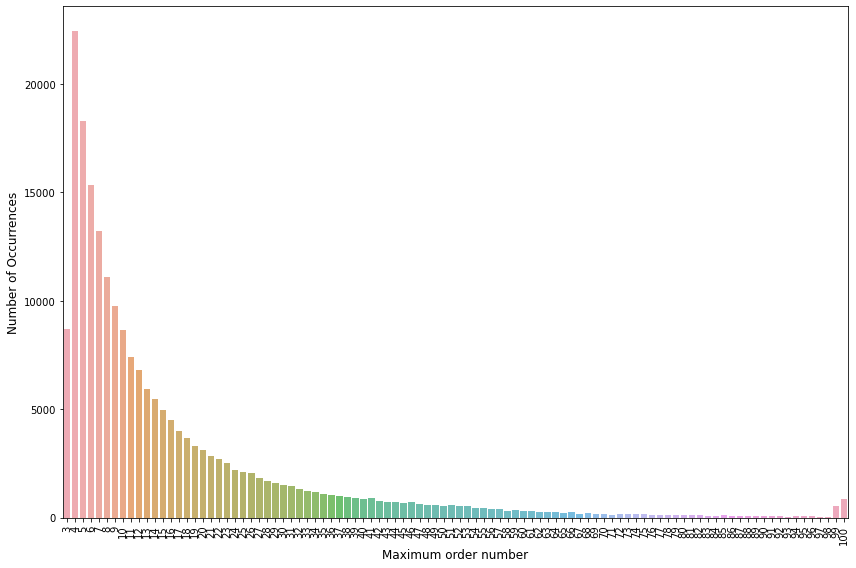

In [8]:
cnt_srs = log.groupby('user_id')['order_number'].max().reset_index()
cnt_srs = cnt_srs.order_number.value_counts().to_pandas()

plt.figure(figsize=(12, 8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

There are no orders less than 4 and is max capped at 100 as given in the data page.

Now let us see how the ordering habit changes with day of week.

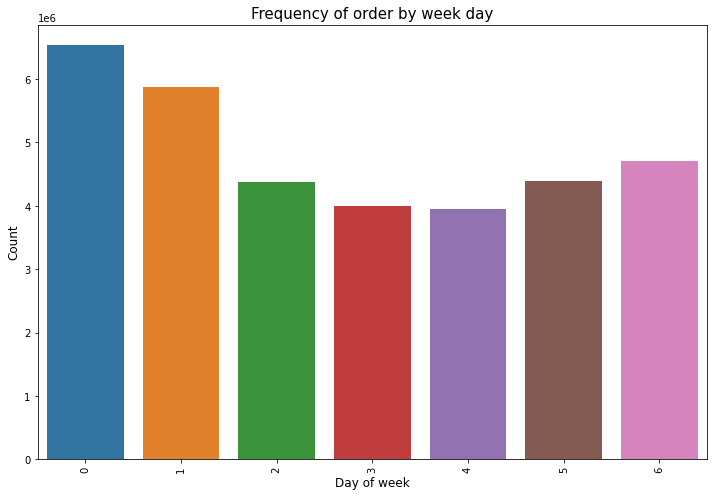

In [9]:
plt.figure(figsize=(12, 8))
sns.countplot(x="order_dow", data=log.to_pandas())
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.

Now we shall see how the distribution is with respect to time of the day.

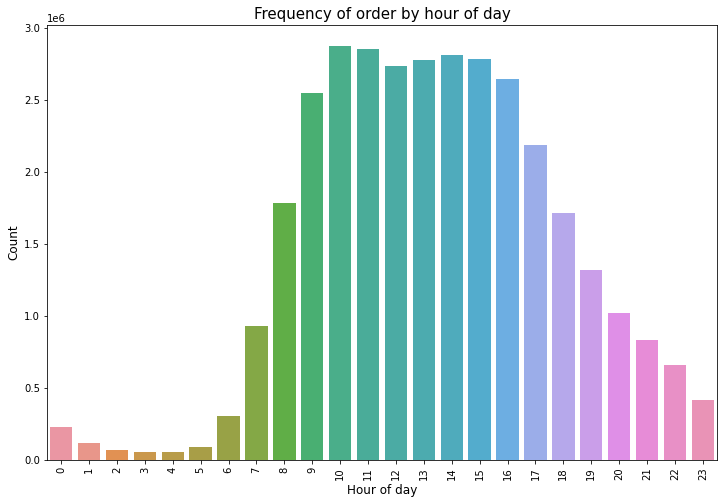

In [10]:
plt.figure(figsize=(12, 8))
sns.countplot(x="order_hour_of_day", data=log.to_pandas())
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

So majority of the orders are made during day time. Now let us combine the day of week and hour of day to see the distribution.

Now let us check the time interval between the orders.

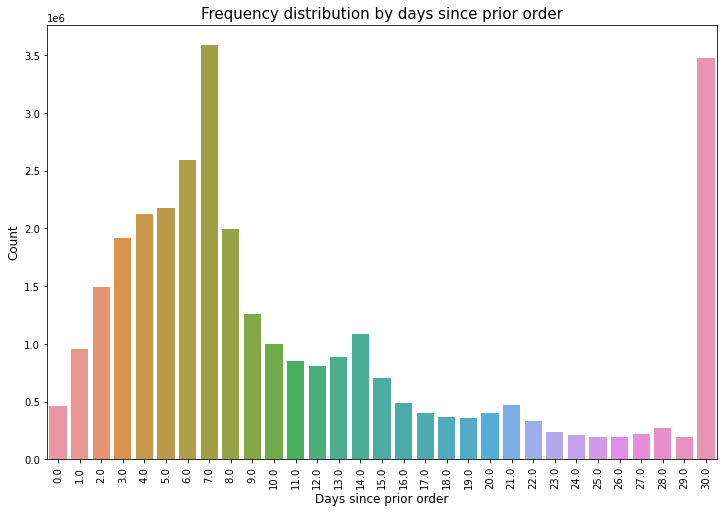

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(x="days_since_prior_order", data=log.to_pandas())
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

Now let us move on to product.

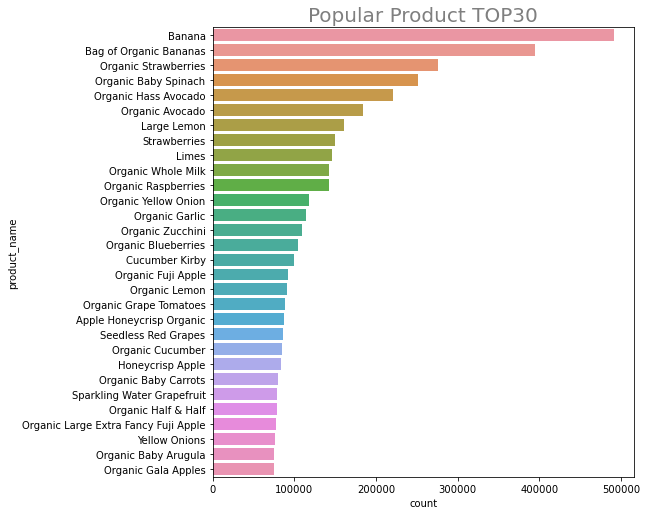

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
df = log.groupby('product_name').size().sort_values(ascending=False).to_pandas().to_frame().reset_index()
df.columns = ['product_name', 'count']
sns.barplot(x='count', y='product_name', data=df.head(30), label='count')
plt.subplots_adjust(left=.4, right=.9)
plt.title('Popular Product TOP{0}'.format(30), fontsize=20, alpha=0.5)
plt.show()

Looks like Banana is the most popular product in Instacart. But we should know if this item is purchased by same user or not.

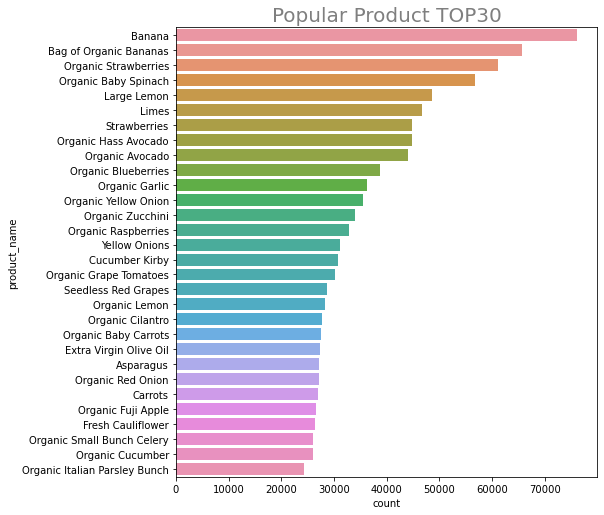

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
df = log.drop_duplicates(['user_id', 'product_id']).groupby('product_name').size().sort_values(ascending=False).to_pandas().to_frame().reset_index()
df.columns = ['product_name', 'count']
sns.barplot(x='count', y='product_name', data=df.head(30), label='count')
plt.subplots_adjust(left=.4, right=.9)
plt.title('Popular Product TOP{0}'.format(30), fontsize=20, alpha=0.5)
plt.show()

This graph shows us that banana is loved by everyone. Over 70k users bought banana.

<a id="feature_engineering"></a>
### 3. Feature Engineering

If Exploratory Data Analysis is the most important part of our data science workflow, Feature Engineering is a close second. This is where we identify which features should be fed into the model and create features where we belive they might be able to help the model do a better job of predicting.

Below, we'll start by just identifying our unique User X Item combintations and sorting them.

In [14]:
train = log[['user_id', 'product_id']].drop_duplicates().sort_values(['user_id', 'product_id'])
train

,user_id,product_id
4254979,1,196
4254981,1,10258
4254983,1,10326
4254980,1,12427
5426143,1,13032
...,...,...
6197782,206209,43961
5431562,206209,44325
18387973,206209,48370
5431560,206209,48697


Next, we'll identify each User's last order number (using the previously created `order_number_inv` column) and using our orders dataset, append that to each user. This will create a dataset where each user maps to their most recent order number and on which day of week, at what hour during the day, and how many days it has been since that order.

In [15]:
df = log[log.order_number_inv==0][['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
df = df.drop_duplicates('user_id')
train = cudf.merge(train, df, how='left', on=['user_id'])
train

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,596,39699,64,1,7,6.0
1,596,39794,64,1,7,6.0
2,596,39928,64,1,7,6.0
3,596,40063,64,1,7,6.0
4,596,40233,64,1,7,6.0
...,...,...,...,...,...,...
13863741,205894,22802,3,4,12,3.0
13863742,205894,26104,3,4,12,3.0
13863743,205894,27845,3,4,12,3.0
13863744,205894,31759,3,4,12,3.0


Here, we'll identify the most recent orders for our users and products and create a column named `label` and assign that value to be 1. We'll then do a left merge using that dataset onto our training dataset and fill in all rows in the column `label` that are `NA` to be of value 0. In a way, we are creating our labels for our training dataset to be used later in our machine learning model. For each row, we can interpret these values to mean that:

* each value 0 means that that particular user did not order that particular item in their most recent order, and
* each value 1 means that that particular **did** order that particular item in their most recent order.

In [16]:
df = log[log.order_number_inv==0][['user_id', 'product_id']]
df['label'] = 1
train = cudf.merge(train, df, how='left', on=['user_id', 'product_id']).fillna(0)
train

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,label
0,175,13166,24,3,9,7.0,0
1,175,13984,24,3,9,7.0,0
2,175,14277,24,3,9,7.0,0
3,175,14332,24,3,9,7.0,0
4,175,14764,24,3,9,7.0,0
...,...,...,...,...,...,...,...
13863741,206153,5586,14,0,8,21.0,0
13863742,206153,8518,14,0,8,21.0,0
13863743,206153,9838,14,0,8,21.0,0
13863744,206153,10069,14,0,8,21.0,0


Lastly, we'll use our `orders` dataset to identify which rows belong to the test dataset and we isolate them. This will result in our test dataset which will be used for submission purposes for Kaggle.

In [17]:
test = cudf.merge(orders[orders.eval_set=='test'], 
                log[['user_id', 'product_id']].drop_duplicates().sort_values(['user_id', 'product_id']),
                how='left',
                on='user_id')
test = test[train.columns[:-1]]
test

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2858,7748,19,4,18,4.0
1,2859,23484,6,2,12,20.0
2,2861,1516,8,6,17,6.0
3,2865,48642,13,2,9,24.0
4,2880,4462,17,3,11,1.0
...,...,...,...,...,...,...
4833287,186520,46505,100,5,21,0.0
4833288,186520,46802,100,5,21,0.0
4833289,186520,46979,100,5,21,0.0
4833290,186520,47144,100,5,21,0.0


<a id="user_features"></a>
#### 3.1. User Features

Now that we have created our `train` and `test` datasets, we will now create features for each of our users, each of our products, and each of our user x product combinations. Below, we create features for our users such as:

* How many kinds of product have user ordered?
* How many products have user ordered within one cart?
* Which department have user ordered products?
* When have user ordered products (day of week)?
* When have user ordered products (hour)?

We will do this for each of our `train` and `test` datasets.

In [18]:
def get_user_features(df):
    feature_list = []
    
    # How many kinds of product have user ordered?
    df_ = df.groupby('user_id').product_id.nunique()
    # df_.name = 'user_product_uq'
    df_.columns = ['user_product_uq']
    feature_list.append(df_)
    
    # How many products have user ordered within one cart?
    df_ = df.groupby(['user_id', 'order_id']).add_to_cart_order.max().reset_index().groupby('user_id').add_to_cart_order.agg(['min', 'mean', 'median', 'max', 'std'])
    # df_ = df_.add_prefix('user_cart-pos_max-')
    df_.columns = ['user_cart-pos_max_'+c for c in df_.columns]
    feature_list.append(df_)
    
    df = df.to_pandas()
    # Which department have user ordered products?
    df_ = pd.crosstab(df.user_id, df.department_id).add_prefix('user_department_').add_suffix('_freq')
    feature_list.append(cudf.from_pandas(df_))
    
    df_ = pd.crosstab(df.user_id, df.department_id, normalize='index').add_prefix('user_department_').add_suffix('_freq-norm')
    feature_list.append(cudf.from_pandas(df_))
    
    # When have user ordered products(day of week)?
    df_ = pd.crosstab(df.user_id, df.order_dow).add_prefix('user_order_dow_').add_suffix('_freq')
    feature_list.append(cudf.from_pandas(df_))
    
    df_ = pd.crosstab(df.user_id, df.order_dow, normalize='index').add_prefix('user_order_dow_').add_suffix('_freq-norm')
    feature_list.append(cudf.from_pandas(df_))
    
    # When have user ordered products(hour)?
    df_ = pd.crosstab(df.user_id, df.order_hour_of_day).add_prefix('user_order_hour_of_day_').add_suffix('_freq')
    feature_list.append(cudf.from_pandas(df_))
    
    df_ = pd.crosstab(df.user_id, df.order_hour_of_day, normalize='index').add_prefix('user_order_hour_of_day_').add_suffix('_freq-norm')
    feature_list.append(cudf.from_pandas(df_))    
    
    features = cudf.concat(feature_list, axis=1)
    
    return features

In [19]:
df = log[log.order_number_inv>0]
train_user_features = get_user_features(df)

In [20]:
test_user_features = get_user_features(log)

<a id="product_features"></a>
#### 3.2. Product Features

Below, we create features for our products such as:

* Which products are orders the most?
* Which products are ordered by the most unique users?
* When products are added, are they added first? Last? On average?
* When have user ordered products (day of week)?
* When have user ordered products (hour)?

We will do this for each of our `train` and `test` datasets.

In [21]:
def get_product_features(df):
    feature_list = []
    
    # Which products are orders the most?
    df_ = df.groupby('product_id').size()
    df_.name = 'product_size'
    feature_list.append(df_)
    
    # Which products are ordered by the most unique users?
    df_ = df.groupby(['product_id', 'user_id']).size().reset_index().groupby('product_id').size()
    df_.name = 'product_size_unq-user'
    feature_list.append(df_)
    
    # When products are added, are they added first? Last? On average?
    df_ = df.groupby('product_id').add_to_cart_order.agg(['min', 'mean', 'median', 'max', 'std'])
    df_.columns = ['product_cart-pos_'+c for c in df_.columns]
    feature_list.append(df_)
    
    df_ = df.groupby('product_id').add_to_cart_order_norm.agg(['min', 'mean', 'median', 'max', 'std'])
    df_.columns = ['product_cart-pos-norm_'+c for c in df_.columns]
    feature_list.append(df_)
    
    df = df.to_pandas()
    # When have user ordered products(day of week)?
    df_ = pd.crosstab(df.product_id, df.order_dow).add_prefix('product_order_dow_').add_suffix('_freq')
    feature_list.append(cudf.from_pandas(df_))
    
    df_ = pd.crosstab(df.product_id, df.order_dow, normalize='index').add_prefix('product_order_dow_').add_suffix('_freq-norm')
    feature_list.append(cudf.from_pandas(df_))
    
    # When have user ordered products(hour)?
    df_ = pd.crosstab(df.product_id, df.order_hour_of_day).add_prefix('product_order_hour_of_day_').add_suffix('_freq')
    feature_list.append(cudf.from_pandas(df_))
    
    df_ = pd.crosstab(df.product_id, df.order_hour_of_day, normalize='index').add_prefix('product_order_hour_of_day_').add_suffix('_freq-norm')
    feature_list.append(cudf.from_pandas(df_))
    
    features = cudf.concat(feature_list, axis=1)
    
    return features

In [22]:
df = log[log.order_number_inv>0]
train_product_features = get_product_features(df)

In [23]:
test_product_features = get_product_features(log)

<a id="user_product_features"></a>
#### 2.3. User X Product Features

Next, we create features for our user x product combinations such as:

* Has this user ordered this product at least once before?
* How many orders has a user placed that has included this item?

We will again do this for each of our `train` and `test` datasets.

In [24]:
def get_user_product_features(df):
    feature_list = []
    
    # Has this user ordered this product at least once before?
    min_ = df.order_number_inv.min()
    df_ = df[df.order_number_inv==min_][['user_id', 'product_id']]
    df_['user_product_t-1'] = 1
    df_ = cudf.merge(train,
                    df_,
                    on=['user_id', 'product_id'],
                    how='left')[['user_id', 'product_id', 'user_product_t-1']].fillna(0)
    df_ = df_.set_index(['user_id', 'product_id'])
    feature_list.append(df_.to_pandas())
    
    # How many orders has a user placed that has included this item?
    df_ = df.groupby(['user_id', 'product_id']).size()
    df_.name = 'user_product_size'
    df_ = df_.reset_index().set_index(['user_id', 'product_id'])
    feature_list.append(df_.to_pandas())    
    
    features = pd.concat(feature_list, axis=1)
    
    return features

In [25]:
df = log[log.order_number_inv>0]
train_user_product_features = get_user_product_features(df)

In [26]:
test_user_product_features = get_user_product_features(log)

In [27]:
train_user_product_features = cudf.from_pandas(train_user_product_features)
test_user_product_features = cudf.from_pandas(test_user_product_features)

<a id="merge"></a>
#### 3.4. Merge

Our last step is to take our `train` and `test` datasets and append to them our features about our users, our products, and our user x product combinations. After this, we'll be ready to build a model from our data!

In [28]:
train = pd.merge(train.to_pandas(), train_user_features.drop('product_id', axis=1).reset_index().to_pandas(), on='user_id', how='left')
train = pd.merge(train, train_product_features.reset_index().to_pandas(), on='product_id', how='left')
train = pd.merge(train, train_user_product_features.reset_index().to_pandas(), on=['user_id', 'product_id'], how='left')

In [29]:
# new
test = pd.merge(test.to_pandas(), test_user_features.drop('product_id', axis=1).reset_index().to_pandas(), on='user_id', how='left')
test = pd.merge(test, test_product_features.reset_index().to_pandas(), on='product_id', how='left')
test = pd.merge(test, test_user_product_features.reset_index().to_pandas(), on=['user_id', 'product_id'], how='left')

In [30]:
train

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,label,user_cart-pos_max_min,user_cart-pos_max_mean,user_cart-pos_max_median,...,product_order_hour_of_day_16_freq-norm,product_order_hour_of_day_17_freq-norm,product_order_hour_of_day_18_freq-norm,product_order_hour_of_day_19_freq-norm,product_order_hour_of_day_20_freq-norm,product_order_hour_of_day_21_freq-norm,product_order_hour_of_day_22_freq-norm,product_order_hour_of_day_23_freq-norm,user_product_t-1,user_product_size
0,175,13166,24,3,9,7.0,0,2,5.652174,5.0,...,0.084551,0.062994,0.051497,0.040559,0.030020,0.021956,0.015329,0.009820,0,2.0
1,175,13984,24,3,9,7.0,0,2,5.652174,5.0,...,0.079094,0.064775,0.051437,0.037221,0.029983,0.024607,0.019644,0.012924,0,2.0
2,175,14277,24,3,9,7.0,0,2,5.652174,5.0,...,0.074468,0.065764,0.050290,0.028046,0.029981,0.014507,0.011605,0.012573,0,1.0
3,175,14332,24,3,9,7.0,0,2,5.652174,5.0,...,0.074763,0.058187,0.048376,0.034337,0.030447,0.026387,0.020467,0.012009,0,1.0
4,175,14764,24,3,9,7.0,0,2,5.652174,5.0,...,0.074866,0.064426,0.050166,0.034123,0.033613,0.026483,0.017825,0.013496,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13863741,206153,5586,14,0,8,21.0,0,3,9.615385,11.0,...,0.067861,0.055917,0.053203,0.040174,0.032573,0.013029,0.010315,0.012486,0,1.0
13863742,206153,8518,14,0,8,21.0,0,3,9.615385,11.0,...,0.078257,0.062212,0.047259,0.036613,0.028244,0.026014,0.022137,0.013938,1,3.0
13863743,206153,9838,14,0,8,21.0,0,3,9.615385,11.0,...,0.058968,0.039312,0.041769,0.056511,0.031941,0.041769,0.012285,0.022113,0,1.0
13863744,206153,10069,14,0,8,21.0,0,3,9.615385,11.0,...,0.100559,0.050279,0.067039,0.027933,0.022346,0.039106,0.011173,0.011173,0,1.0


In [31]:
test

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_cart-pos_max_min,user_cart-pos_max_mean,user_cart-pos_max_median,user_cart-pos_max_max,...,product_order_hour_of_day_16_freq-norm,product_order_hour_of_day_17_freq-norm,product_order_hour_of_day_18_freq-norm,product_order_hour_of_day_19_freq-norm,product_order_hour_of_day_20_freq-norm,product_order_hour_of_day_21_freq-norm,product_order_hour_of_day_22_freq-norm,product_order_hour_of_day_23_freq-norm,user_product_t-1,user_product_size
0,2858,7748,19,4,18,4.0,1,8.277778,9.0,18,...,0.080429,0.058981,0.050938,0.045576,0.013405,0.010724,0.008043,0.002681,0,1
1,2859,23484,6,2,12,20.0,2,5.000000,4.0,12,...,0.061674,0.056290,0.042095,0.039648,0.034263,0.040137,0.023495,0.016153,0,1
2,2861,1516,8,6,17,6.0,6,8.714286,9.0,12,...,0.078137,0.068145,0.053757,0.040568,0.027978,0.025580,0.018385,0.013389,0,1
3,2865,48642,13,2,9,24.0,4,10.750000,10.5,19,...,0.070648,0.067844,0.048220,0.045977,0.032520,0.029437,0.017662,0.010093,0,1
4,2880,4462,17,3,11,1.0,1,3.125000,3.0,6,...,0.091978,0.064790,0.048785,0.041651,0.029117,0.019476,0.016776,0.012148,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,186520,46505,100,5,21,0.0,1,6.161616,5.0,17,...,0.078659,0.061131,0.048203,0.037467,0.037248,0.028484,0.025855,0.015118,0,1
4833288,186520,46802,100,5,21,0.0,1,6.161616,5.0,17,...,0.080263,0.066469,0.052522,0.041111,0.031698,0.024129,0.022246,0.013755,0,1
4833289,186520,46979,100,5,21,0.0,1,6.161616,5.0,17,...,0.078875,0.067294,0.047589,0.036177,0.028545,0.024933,0.020759,0.012804,0,1
4833290,186520,47144,100,5,21,0.0,1,6.161616,5.0,17,...,0.073513,0.065801,0.050266,0.039115,0.028573,0.021804,0.017172,0.012483,0,4


<a id="train"></a>
### 4. Train and Predict

The mathematical operations underlying many machine learning algorithms are often matrix multiplications. These types of operations are highly parallelizable and can be greatly accelerated using a GPU. RAPIDS makes it easy to build machine learning models in an accelerated fashion while still using an interface nearly identical to Scikit-Learn and XGBoost. 

There are many ways to create a model - one can use Linear Regression models, SVMs, tree-based models like Random Forest and XGBoost, or even Neural Networks. In general, tree-based models tend to work better with tabular data for forecasting than Neural Networks. Neural Networks work by mapping the input (feature space) to another complex boundary space and determining what values should belong to those points within that boundary space (regression, classification). Tree-based models on the other hand work by taking the data, identifying a column, and then finding a split point in that column to map a value to, all the while optimizing the accuracy. We can create multiple trees using different columns, and even different columns within each tree. 

<div style="text-align:center"><img src="./images/twocart.png"/></div>

For a more detailed description of tree-based models XGBoost, see this fantastic documentation: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In addition to their better accuracy performance, tree-based models are very easy to interpet (important for when predictions or decisions resutling from the predictions have to be explained and justified, maybe for compliance and legal reasons e.g. finance, insurance, healthcare). Tree-based models are very robust and work well even when there's a small set of data points. Both attributes which are sometimes more difficult for complex models like Neural Networks.

In the section below, we'll set the different parameters for our XGBoost model and train 5 different models - each on a different subset of users so as to avoid overfitting to a particular set of users.

There are a number of parameters that can be set before XGBoost can be run. 

* General parameters relate to which booster we are using to do boosting, commonly tree or linear model
* Booster parameters depend on which booster you have chosen
* Learning task parameters decide on the learning scenario. For example, regression tasks may use different parameters with ranking tasks.

For more information on the configurable parameters within the XGBoost module, see the documentation here: https://xgboost.readthedocs.io/en/latest/parameter.html

In [32]:
import xgboost as xgb


NFOLD = 5

PARAMS = {
    'max_depth':8, 
    'eta':0.1,
    'colsample_bytree':0.4,
    'subsample':0.75,
    'silent':1,
    'nthread':40,
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist'
         }

Now it's time to train our model! We can use the `xgb.train` function and pass in the parameters, training dataset, the number of boosting iterations, and the list of items to be evaluated during training. For more information on the parameters that can be passed into `xgb.train`, check out the documentation:

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.train

In [33]:
models = []
for i in range(NFOLD):
    train_ = train[train.user_id % NFOLD != i]
    valid_ = train[train.user_id % NFOLD == i]
    dtrain = xgb.DMatrix(train_.drop(['user_id', 'product_id', 'label'], axis=1), train_['label'])
    dvalid = xgb.DMatrix(valid_.drop(['user_id', 'product_id', 'label'], axis=1), valid_['label'])
    
    model = xgb.train(PARAMS, dtrain, 9999, [(dtrain, 'train'),(dvalid, 'valid')],
                      early_stopping_rounds=50, verbose_eval=5)
    models.append(model)
    
    break

[00:53:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1612969655237/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.64567	valid-logloss:0.64571
[5]	train-logloss:0.46816	valid-logloss:0.46844
[10]	train-logloss:0.40757	valid-logloss:0.40802
[15]	train-logloss:0.36194	valid-logloss:0.36270
[20]	train-logloss:0.32540	valid-logloss:0.32643
[25]	train-logloss:0.30753	valid-logloss:0.30885
[30]	train-logloss:0.28941	valid-logloss:0.29095
[35]	train-logloss:0.26904	valid-logloss:0.27080
[40]	train-logloss:0.25954	valid-logloss:0.26147
[45]	train-logloss:0.25253	valid-logloss:0.25465
[50]	train-logloss:0.24826	valid-logloss:0.25056
[55]	train-logloss:0.24591	valid-logloss:0.24835
[60]	train-logloss:0.24491	vali

Since we're using 5 different models, we'll need to generate predictions for each of our models, add them all together, and divide by our number of models. This is a commonly used technique in forecasting called ensembling - it is very useful for avoiding overfitting and generating robust predictions that perform well in the real world.

In [34]:
pred = np.zeros(len(test))

In [35]:
for m in models:
    pred += m.predict(xgb.DMatrix(test.drop(['user_id', 'product_id'], axis=1)))
pred /= len(models)

In [36]:
pred

array([0.03492919, 0.04101116, 0.05693459, ..., 0.01509598, 0.03421621,
       0.01308606])

<a id="feature_importance"></a>
### 5. Feature Importance

Now that we've trained our models, we might want to take a look at the internal workings and understand which of the features we've crafted are contributing the most to the predictions. This is called Feature Importance. One of the advantages for tree-based models for forecasting is that understanding the different importances of our features is very easy.

Once we understand how our features contribute to the model accuracy, we can choose to remove features that aren't important or try to iterate and create new features, re-train, and re-assess if those new features are more important. Ultimately, being able to iterate quickly and try new things in this workflow will lead to the most accurate model and the greatest ROI (for forecasting, oftentimes cost-savings from reduced out-of-stock and poorly placed inventory).

Below, we write some convenience code to access the importance of the features in each model. We then pass in our list of models that we tained, iterate over them one by one, and average the importance of each variable across all the models. Lastly, we visualize the importances using a horizontal bar chart.

Below, we see specifically that 3 of our features are contributing the most to our predictions: :

* `user_product_size` - How many orders has a user placed that has included this item?
* `user_product_t-1` - Has this user ordered this product at least once before?
* `order_number` - The number of orders that user has created

All of this makes sense and aligns with our business understanding of the problem. Customers who have placed an order for an item before are more likely to repeat an order for that product, and users who place multiple orders of that product are even more likely to re-order. Additionally, the number of orders a customer has created correlates with their likelihood of re-ordering.

The below code uses the default XGBoost implementation of feature importance - but we are free to choose any implementation or technique. A wonderful technique (also developed by an NVIDIA Kaggle Grandmaster) is called LOFO. 

LOFO (Leave One Feature Out) Importance calculates the importances of a set of features based on a metric of choice, for a model of choice, by iteratively removing each feature from the set, and evaluating the performance of the model, with a validation scheme of choice, based on the chosen metric.

LOFO first evaluates the performance of the model with all the input features included, then iteratively removes one feature at a time, retrains the model, and evaluates its performance on a validation set. The mean and standard deviation (across the folds) of the importance of each feature is then reported.

LOFO has several advantages compared to other importance types:

* It does not favor granular features
* It generalises well to unseen test sets
* It is model agnostic
* It gives negative importance to features that hurt performance upon inclusion
* It can group the features. Especially useful for high dimensional features like TFIDF or OHE features.

For more information on LOFO, see here: https://github.com/aerdem4/lofo-importance

In [37]:
def __get_imp__(model):
    for i in ['weight', 'gain', 'cover']:
        imp_ = model.get_score(importance_type=i)
        imp_ = pd.DataFrame(list(imp_.items()))
        imp_.columns = ['col',i]
        if i == 'weight':
            imp = imp_
        else:
            imp = pd.merge(imp, imp_, on='col', how='outer')
    imp.sort_values('gain', ascending=False, inplace=True)
    imp.set_index('col', inplace=True)
    return imp.fillna(0)

def get_imp(models):
    """
    models: list of model
    [model1, model2,...]
    or model
    
    return:
    averaged importance
    """
    if isinstance(models, list):
        for i,m in enumerate(models):
            if i==0:
                imp = __get_imp__(m)
            else:
                imp += __get_imp__(m)
        imp /= (i+1)
    else:
        imp = __get_imp__(models)
    
    imp.sort_values('gain',ascending=False,inplace=True)
    imp.reset_index(inplace=True)
    imp.columns = ['feature', 'weight', 'gain', 'cover']
    return imp

imp = get_imp(m)

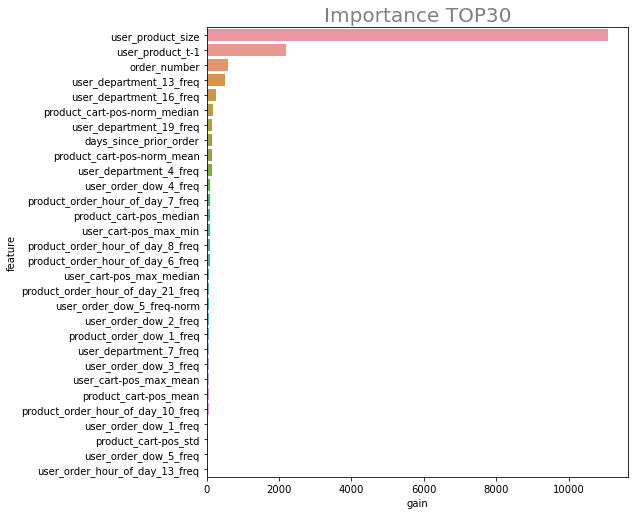

In [38]:
def plt_imp(imp, x='gain', y='feature', n=30, title='Importance'):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.barplot(x=x, y=y, data=imp.head(n), label=x)
    plt.subplots_adjust(left=.4, right=.9)
    plt.title(title+' TOP{0}'.format(n), fontsize=20, alpha=0.5)
    plt.show()

plt_imp(imp)

<a id="hpo"></a>
### 6. Hyperparamater Optimization (HPO)

When we trained our XGBoost models, we used the following parameters:

```
PARAMS = {
    'max_depth':8, 
    'eta':0.1,
    'colsample_bytree':0.4,
    'subsample':0.75,
    'silent':1,
    'nthread':40,
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist'
         }
```

Of these, only a few may actually be changed and effect the accuracy of our model: `max_depth`, `eta`, `colsample_bytree`, and `subsample`. However, these may not be the most optimal parameters. The art and science of identifying and training models with the model optimal hyperparamers is called hyperparameter optimization. 

While there is no magic button one can press to automatically identify the most optimal hyperparameters, there are techniques that allow you to explore the range of all possible hyperparameter values, quickly test them, and find values that are closest.

A full exploration of these techniques is beyond the scope of this notebook. However, RAPIDS is integrated into many Cloud ML Frameworks for doing HPO as well as with many of the different open source tools. And being able to use the incredible speedups from RAPIDS allows you to go through your ETL, feature engineering, and model training workflow very quickly for each possible experiement - ultimately resulting in fast HPO explorations through large hyperparameter spaces and a significant reduction in Total Cost of Ownership (TCO).

<div style="text-align:center"><img src="./images/hpo.png"/></div>

For more details on the various techniques in hyperparamter optimization that work with RAPIDS, see here: https://rapids.ai/hpo.html

<a id="conclusion"></a>
### 7. Conclusion

In this notebook, we showed best practices for GPU accelerated forecasting within the context of the Instacart Market Basket Analysis Kaggle competetion in which NVIDIA Kaggle Grandmaster Kazuki Onodera won 2nd place, using complex feature engineering, gradient boosted tree models, and special modeling of the competition’s F1 evaluation metric. 

To learn more about RAPIDS, be sure to check out: 

* [Open Source Website](http://rapids.ai)
* [GitHub](https://github.com/rapidsai/)
* [Press Release](https://nvidianews.nvidia.com/news/nvidia-introduces-rapids-open-source-gpu-acceleration-platform-for-large-scale-data-analytics-and-machine-learning)
* [NVIDIA Blog](https://blogs.nvidia.com/blog/2018/10/10/rapids-data-science-open-source-community/)
* [Developer Blog](https://devblogs.nvidia.com/gpu-accelerated-analytics-rapids/)
* [NVIDIA Data Science Webpage](https://www.nvidia.com/en-us/deep-learning-ai/solutions/data-science/)